# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [9]:
df = pd.read_csv('bikes_rent.csv')
# Виведення перших 5 рядків
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

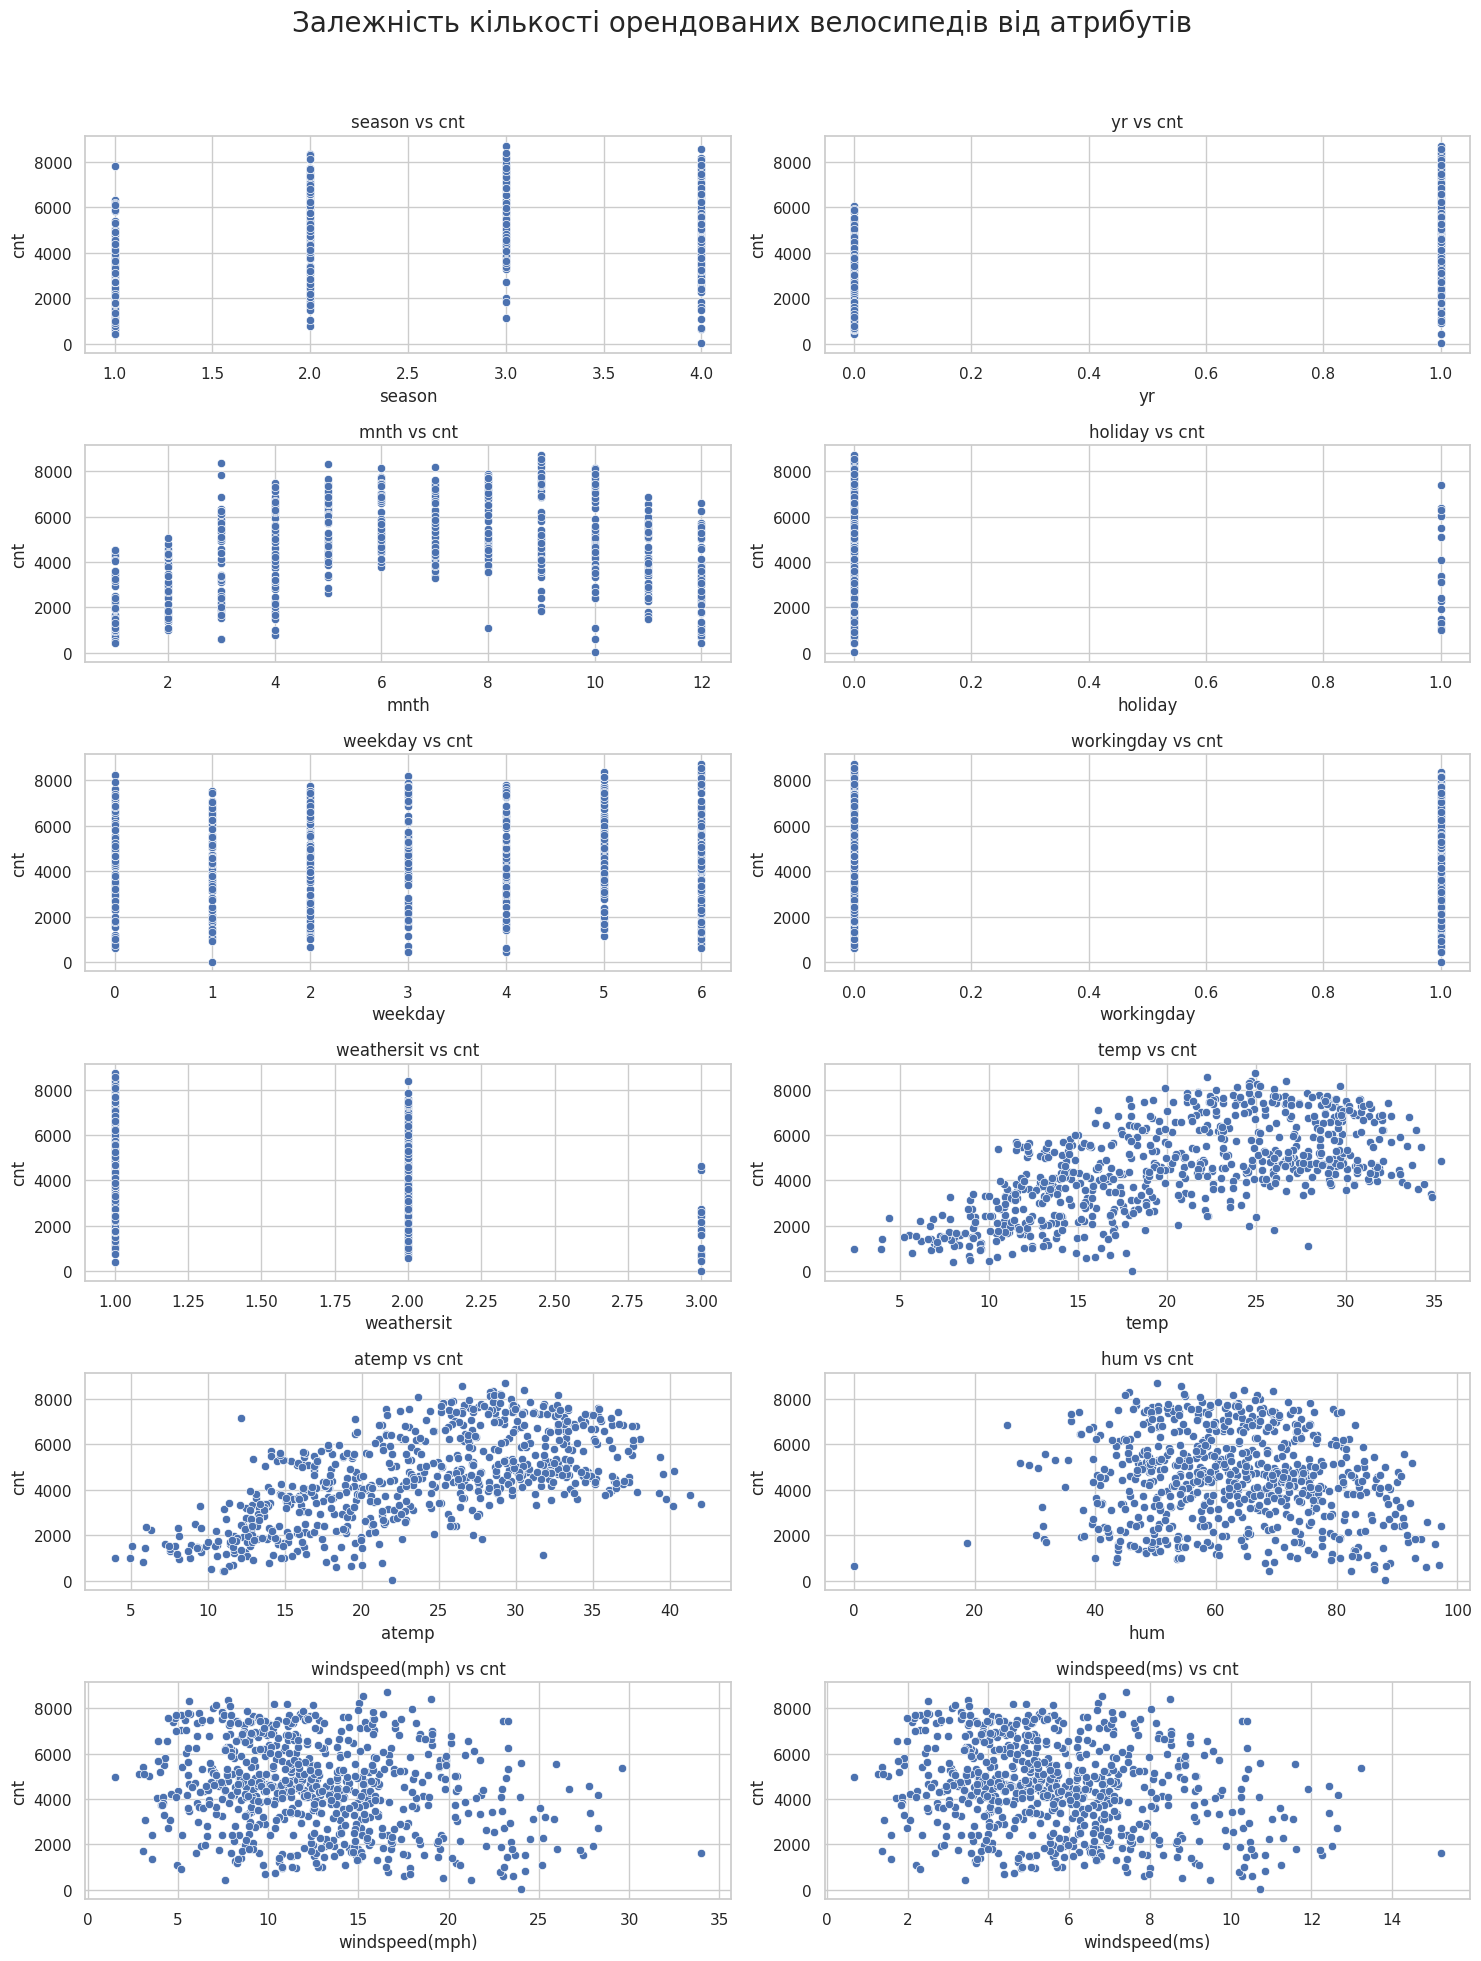

In [10]:
import seaborn as sns

# Встановлення стилю для графіків
sns.set(style="whitegrid")

# Створення фігури для графіків
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
fig.suptitle('Залежність кількості орендованих велосипедів від атрибутів', fontsize=20)

# Список атрибутів
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Побудова графіків
for i, attribute in enumerate(attributes):
    row, col = i // 2, i % 2
    sns.scatterplot(x=attribute, y='cnt', data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{attribute} vs cnt')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

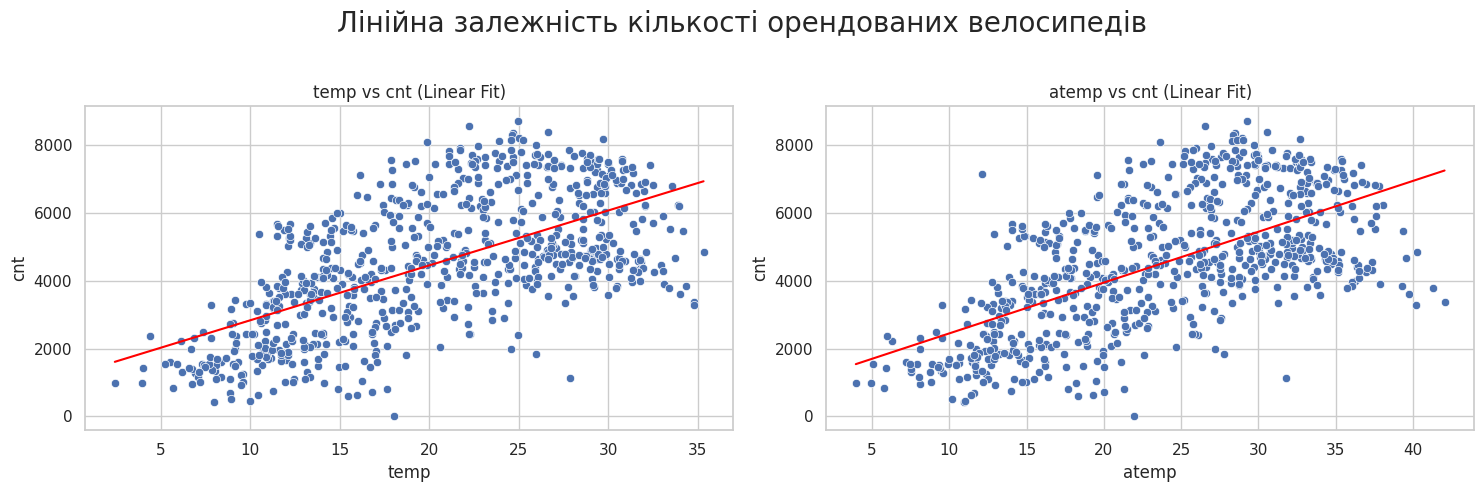

In [11]:
from sklearn.linear_model import LinearRegression


# Функція для побудови лінійної регресії
def plot_linear_regression(attribute, ax):
    X = df[[attribute]]
    y = df['cnt']
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    sns.scatterplot(x=attribute, y='cnt', data=df, ax=ax)
    sns.lineplot(x=df[attribute], y=y_pred, color='red', ax=ax)
    ax.set_title(f'{attribute} vs cnt (Linear Fit)')

# Створення фігури для лінійних регресій
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Лінійна залежність кількості орендованих велосипедів', fontsize=20)

# Побудова графіків лінійної регресії для temp та atemp
plot_linear_regression('temp', axes[0])
plot_linear_regression('atemp', axes[1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [12]:
# Виведення перших 5 рядків
print(df.head())

# Обчислення кореляцій Пірсона всіх ознак з цільовою змінною 'cnt'
correlations = df.corrwith(df['cnt'])

# Виведення результатів
print(correlations)

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.2

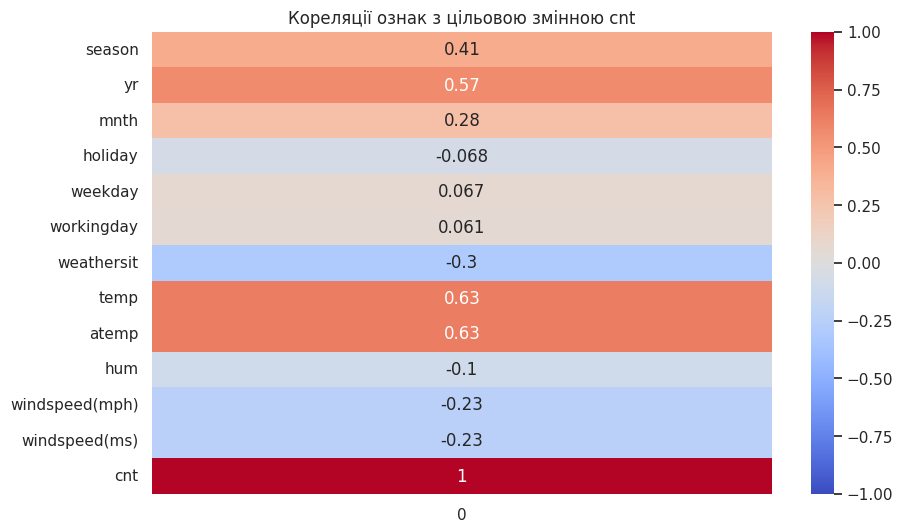

In [13]:
# Побудова теплової карти кореляцій
plt.figure(figsize=(10, 6))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Кореляції ознак з цільовою змінною cnt')
plt.show()

Кореляція Пірсона вимірює лінійну залежність між двома змінними. Вона приймає значення від -1 до 1, де:
1 означає повну позитивну лінійну залежність,
-1 означає повну негативну лінійну залежність,
0 означає відсутність лінійної залежності.
Цей додатковий код створить теплову карту, яка візуально покаже рівень кореляції кожної ознаки з цільовою змінною.

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  
                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.00184

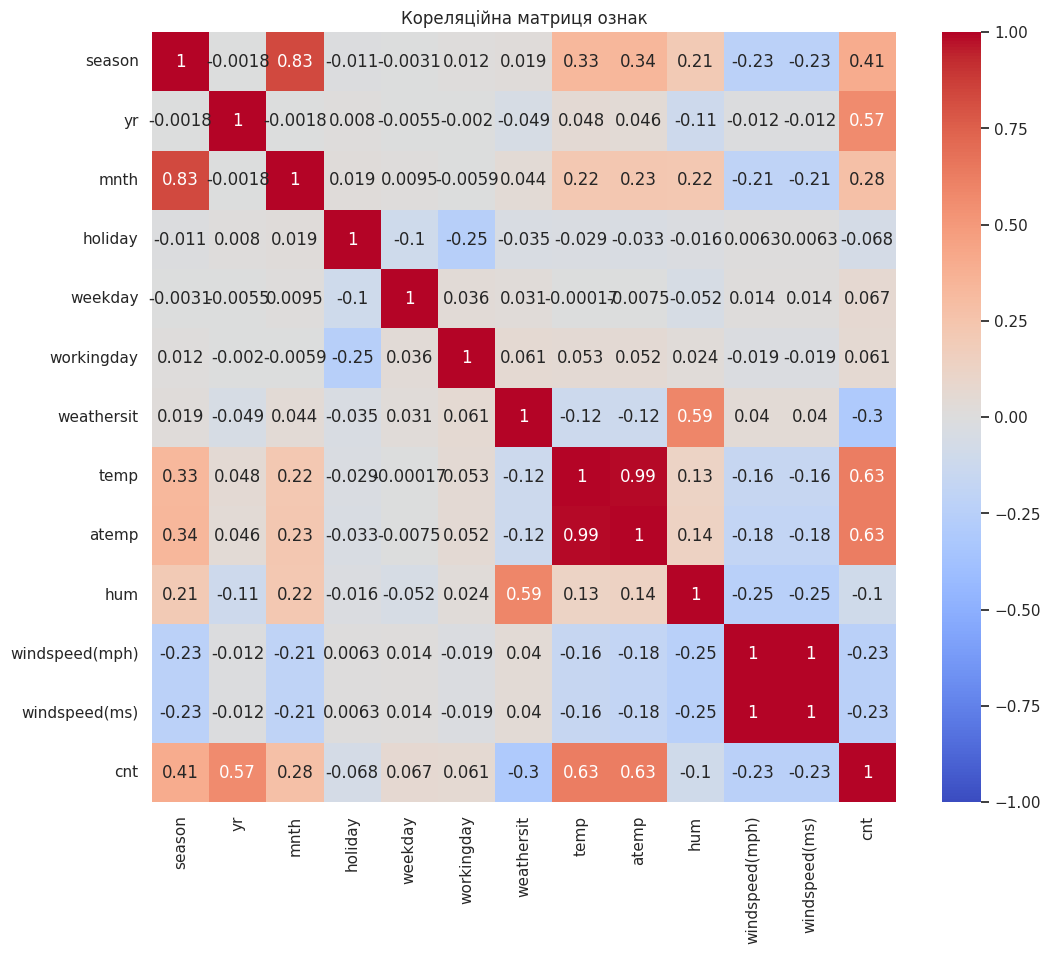

In [14]:
# Виведення перших 5 рядків
print(df.head())

# Обчислення кореляційної матриці
correlation_matrix = df.corr()

# Виведення кореляційної матриці
print(correlation_matrix)

# Побудова теплової карти кореляційної матриці
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Кореляційна матриця ознак')
plt.show()

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [15]:
# Вибір потрібних ознак
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислення кореляційної матриці для вибраних ознак
correlation_matrix = df[selected_features].corr()

# Виведення кореляційної матриці
print(correlation_matrix)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

In [16]:
# Обчислення середніх значень ознак
means = df.mean()

# Виведення результатів
print(means)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки з середніми значеннями близькими до 0 або 1 є бінарними.

Ознаки з більшими середніми значеннями є числовими і можуть мати різний масштаб.

## Завдання 4

Виведіть середні ознак.

In [17]:
# Обчислення середніх значень ознак
means = df.mean()

# Виведення результатів
print(means)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [24]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


# Вибір потрібних ознак для стандартизації
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Створення датафрейму з обраними ознаками
df_selected = df[features]

# Стандартизація ознак
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected)

# Перетворення назад у DataFrame для зручності
df_scaled = pd.DataFrame(scaled_features, columns=features)

# Перемішування вибірки
df_shuffled = shuffle(df_scaled, random_state=42)

# Виведення перших 5 рядків стандартизованого та перемішаного датасету
print(df_shuffled.head())

       season        yr      mnth   holiday   weekday  workingday  weathersit  \
703  1.354375  0.998633  1.588660 -0.171981 -0.497782    0.679706   -0.726048   
33  -1.348213 -1.001369 -1.310268 -0.171981  0.500513    0.679706   -0.726048   
300  1.354375 -1.001369  1.008875 -0.171981  0.999661    0.679706    1.110427   
456 -0.447350  0.998633 -0.730482 -0.171981 -1.496077   -1.471225    1.110427   
633  1.354375  0.998633  0.718982 -0.171981 -0.497782    0.679706   -0.726048   

         temp     atemp       hum  windspeed(mph)  windspeed(ms)       cnt  
703 -0.106884 -0.032545  0.743727       -0.211211      -0.211211  1.085628  
33  -1.686082 -1.820550 -1.335389        1.126812       1.126812 -1.526097  
300 -0.899555 -0.955126 -0.295514        0.503491       0.503491 -0.391216  
456 -0.380219 -0.350427  0.339741       -0.235254      -0.235254  0.793772  
633  0.298565  0.428770 -0.406755        0.591838       0.591838  1.567061  


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [25]:
from sklearn.linear_model import LinearRegression

# Вибір потрібних ознак для стандартизації
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
target = 'cnt'

# Створення датафрейму з обраними ознаками та цільовою змінною
df_selected = df[features + [target]]

# Стандартизація ознак
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# Перетворення назад у DataFrame для зручності
df_scaled = pd.DataFrame(scaled_features, columns=features)

# Додавання цільової змінної
df_scaled[target] = df_selected[target]

# Перемішування вибірки
df_shuffled = shuffle(df_scaled, random_state=42)

# Розділення на вхідні ознаки (X) і цільову змінну (y)
X = df_shuffled[features]
y = df_shuffled[target]

# Навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X, y)

# Виведення ваг ознак
weights = pd.Series(model.coef_, index=features)
print("Ваги ознак:")
print(weights)

Ваги ознак:
season            5.708633e+02
yr                1.021971e+03
mnth             -1.413013e+02
holiday          -8.675837e+01
weekday           1.372228e+02
workingday        5.639237e+01
weathersit       -3.302281e+02
temp              3.674588e+02
atemp             5.855745e+02
hum              -1.456130e+02
windspeed(mph)    1.245889e+13
windspeed(ms)    -1.245889e+13
dtype: float64


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [26]:
# Розділення на вхідні ознаки (X) і цільову змінну (y)
X = df.drop(columns=['cnt'])  # всі ознаки, окрім 'cnt'
y = df['cnt']  # цільова змінна

# Створення та навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X, y)

# Виведення пар (назва ознаки, вага)
print("Ваги моделі:")
for feature, coef in zip(df.columns, model.coef_):
    print(feature, coef)

Ваги моделі:
season 514.2756689772416
yr 2043.9333206099773
mnth -40.96317631503962
holiday -519.3860417173415
weekday 68.49569506058863
workingday 121.29281595858514
weathersit -606.4542679476724
temp 48.994172947818015
atemp 71.9163310082323
hum -10.230641893838651
windspeed(mph) 2400995993962.544
windspeed(ms) -5371028038579.01


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

In [27]:
from sklearn.linear_model import Lasso

# Створення та навчання моделі Lasso
lasso_model = Lasso(alpha=0.1)  # встановлюємо параметр регуляризації alpha
lasso_model.fit(X, y)

# Виведення пар (назва ознаки, вага)
print("Ваги моделі Lasso:")
for feature, coef in zip(df.columns, lasso_model.coef_):
    print(feature, coef)


Ваги моделі Lasso:
season 509.45281497893234
yr 2040.2562174173866
mnth -38.88943663224555
holiday -515.5580898949975
weekday 69.04981421568401
workingday 120.16602821966354
weathersit -610.345033259382
temp 49.67420564301338
atemp 71.30957010367258
hum -10.205021038962116
windspeed(mph) -38.189535709463755
windspeed(ms) -0.0


In [28]:
from sklearn.linear_model import Ridge

# Створення та навчання моделі Ridge
ridge_model = Ridge(alpha=0.1)  # встановлюємо параметр регуляризації alpha
ridge_model.fit(X, y)

# Виведення пар (назва ознаки, вага)
print("Ваги моделі Ridge:")
for feature, coef in zip(df.columns, ridge_model.coef_):
    print(feature, coef)


Ваги моделі Ridge:
season 509.5782159252485
yr 2039.535710540727
mnth -38.928915350570186
holiday -516.2976242366768
weekday 69.06827585162819
workingday 120.48499309007839
weathersit -610.4036406685196
temp 49.46796667367069
atemp 71.49849217290618
hum -10.208233218331769
windspeed(mph) -31.82709434300982
windspeed(ms) -14.22758074505081


### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [34]:
# Навчання моделі Lasso
lasso_model = Lasso()
lasso_model.fit(X, y)

# Виведення ваг моделі Lasso
print("Ваги моделі Lasso:")
for feature, coef in zip(df.columns, lasso_model.coef_):
    print(feature, coef)

Ваги моделі Lasso:
season 506.5512786498074
yr 2036.2316676979037
mnth -38.07827028932167
holiday -484.65194618654056
weekday 68.93837479133958
workingday 118.4475975866837
weathersit -604.5667118927049
temp 51.363260585616366
atemp 69.91273749012187
hum -10.352705204636573
windspeed(mph) -38.34106761310847
windspeed(ms) -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [35]:
# Навчання моделі Ridge
ridge_model = Ridge()
ridge_model.fit(X, y)

# Виведення ваг моделі Ridge
print("\nВаги моделі Ridge:")
for feature, coef in zip(df.columns, ridge_model.coef_):
    print(feature, coef)


Ваги моделі Ridge:
season 507.8018818505763
yr 2029.0890541970502
mnth -38.470897279124635
holiday -493.2780154838191
weekday 69.11396965165964
workingday 121.5244250292943
weathersit -605.205555373153
temp 49.31676759598743
atemp 71.7859872733456
hum -10.383394500484615
windspeed(mph) -31.93550169428455
windspeed(ms) -14.276040263842843


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [38]:
# Значення коефіцієнта регуляризації α
alphas = [0.01, 0.1, 1, 10, 100]

# Списки для зберігання ваг
coefs_lasso = []
coefs_ridge = []

# Навчання моделей для кожного значення α
for alpha in alphas:
    # Навчання моделі Lasso
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    # Навчання моделі Ridge
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

# Конвертація списків в np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(coefs_lasso)
print(coefs_ridge)

[[ 509.74296257 2040.65867996  -38.97055213 -518.64859449   69.06097068
   120.33788653 -610.92282714   49.5048134    71.449701    -10.19025515
   -38.17436672   -0.        ]
 [ 509.45281498 2040.25621742  -38.88943663 -515.55808989   69.04981422
   120.16602822 -610.34503326   49.67420564   71.3095701   -10.20502104
   -38.18953571   -0.        ]
 [ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 477.32591467 1996.24931816  -29.92697086 -171.77719511   68.25910797
   101.79300668 -545.45447186   51.34556518   71.49410924  -11.91744494
   -39.30755407   -0.        ]
 [ 297.07442417 1608.4605901     9.23821408   -0.           37.80311401
     0.           -4.85009184   37.3541199    95.92588228  -26.3545609
   -48.10976518   -0.        ]]
[[ 5.09755504e+02  2.04058657e+03 -3.89745019e+01 -5.18721206e+02
   6.90628316e+01  1.20369909e+02 -6.10928618e+02  4.9483970

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

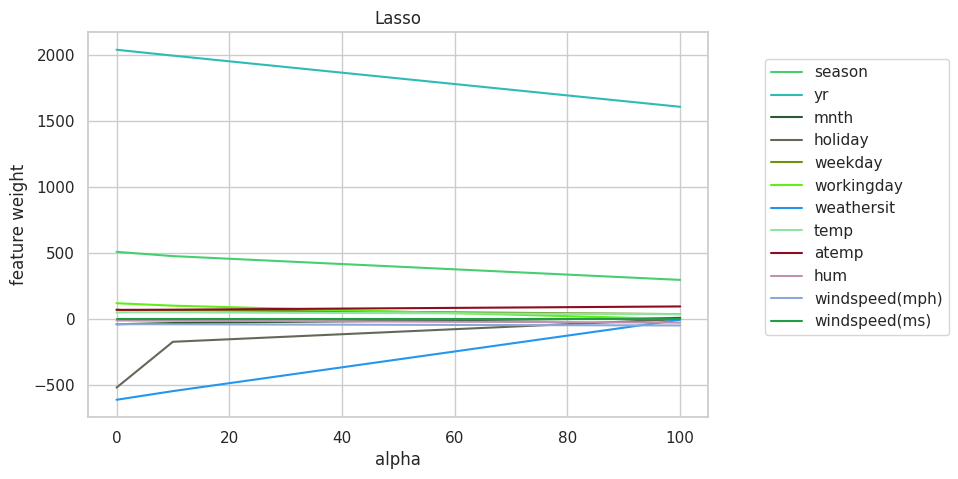

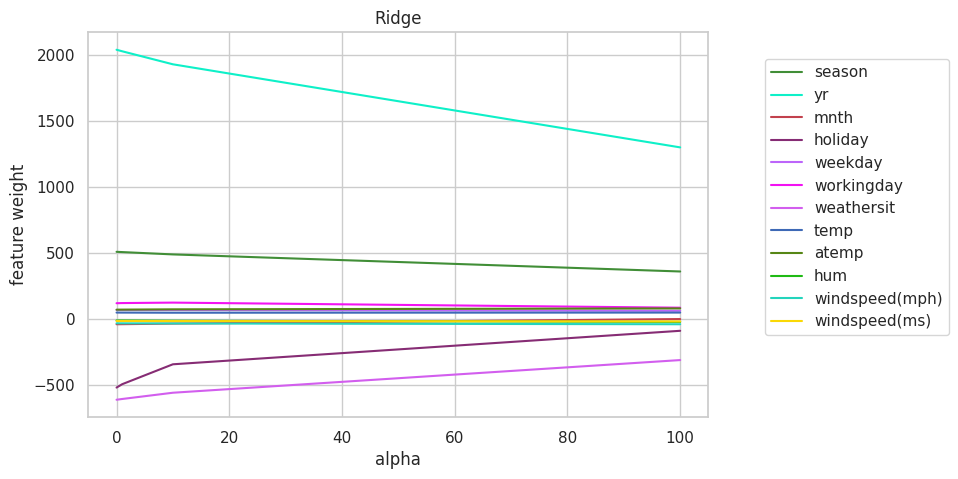

In [39]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?

<font color='red'> Lasso-регуляризатор агресивніше зменшує ваги при одному й тому самому alpha порівняно з Ridge-регуляризатором. Це через те, що Lasso включає в оптимізаційну функцію штраф за абсолютні значення коефіцієнтів, що призводить до занулення деяких коефіцієнтів. Ridge, з іншого боку, включає штраф за квадратичні значення коефіцієнтів, але не занулює їх. </font>

1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.

<font color='red'> При дуже великих значеннях alpha Lasso-регуляризатор може занулити всі ваги (крім константного члена). Це відбувається тому, що штраф за абсолютні значення коефіцієнтів стає дуже великим, і оптимізаційний процес спрямований на зменшення ваг до мінімуму.</font>

1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.

<font color='red'> Так, Lasso зазвичай виключає одну з ознак windspeed при будь-якому значенні alpha > 0, оскільки штраф за абсолютні значення коефіцієнтів призводить до занулення деяких коефіцієнтів. У випадку Ridge, оскільки штраф за квадратичні значення коефіцієнтів не приводить до занулення, Ridge не виключає ознаку windspeed навіть при малих значеннях alpha.</font>

1. Який із регуляризаторів підійде для відбору неінформативних ознак?

<font color='red'> Lasso підходить краще для відбору неінформативних ознак, оскільки він штрафує коефіцієнти, які не впливають на цільову змінну, і може занулити їх, тим самим виключаючи їх з моделі. Ridge також може допомогти зменшити ваги неінформативних ознак, але він не виключає їх з моделі так ефективно, як Lasso.</font>


### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

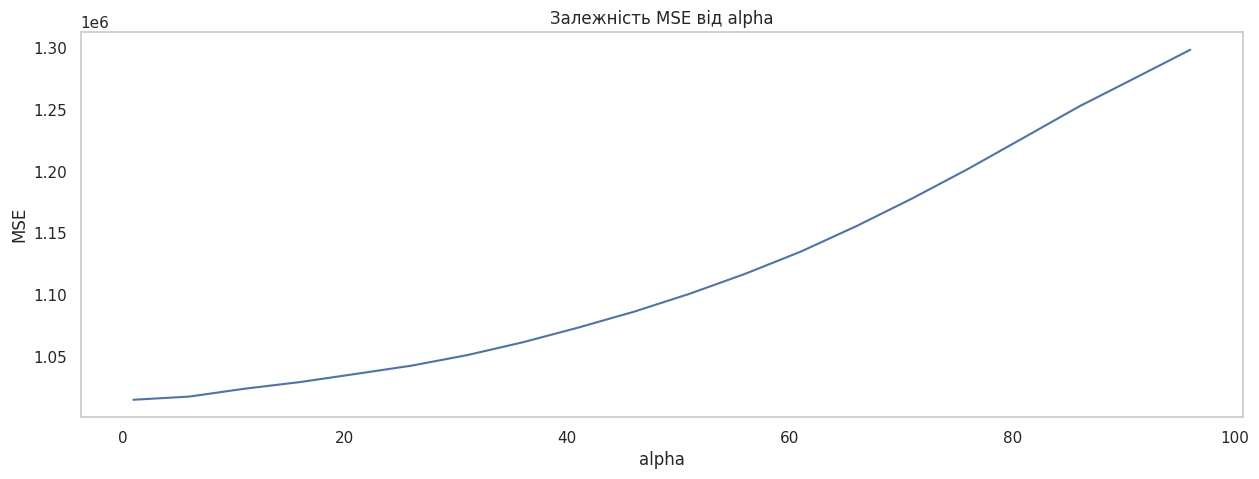

Вибране alpha: 1
Пари 'ознака-коефіцієнт': [('season', 506.5512786498074), ('yr', 2036.2316676979037), ('mnth', -38.07827028932167), ('holiday', -484.65194618654056), ('weekday', 68.93837479133958), ('workingday', 118.4475975866837), ('weathersit', -604.5667118927049), ('temp', 51.363260585616366), ('atemp', 69.91273749012187), ('hum', -10.352705204636573), ('windspeed(mph)', -38.34106761310847), ('windspeed(ms)', -0.0)]


In [45]:
from sklearn.linear_model import LassoCV

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas)
regressor.fit(X, y)

mse_avg = np.mean(regressor.mse_path_, axis=1)
alpha_selected = regressor.alpha_
coefs = list(zip(df.columns[:-1], regressor.coef_))

create_plot(list(zip(regressor.alphas_, mse_avg)), 'Залежність MSE від alpha', 'alpha', 'MSE')

print("Вибране alpha:", alpha_selected)
print("Пари 'ознака-коефіцієнт':", coefs)

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

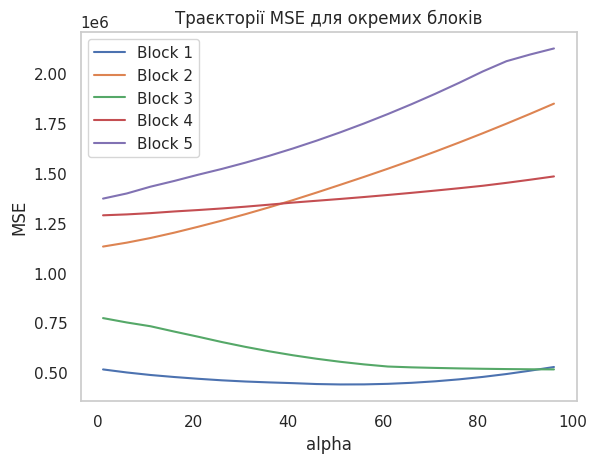

In [46]:
for i in range(regressor.mse_path_.shape[1]):
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f'Block {i+1}')

plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Траєкторії MSE для окремих блоків')
plt.legend()
plt.grid()
plt.show()


### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Block 1: 51
Block 2: 1
Block 3: 96
Block 4: 1
Block 5: 1


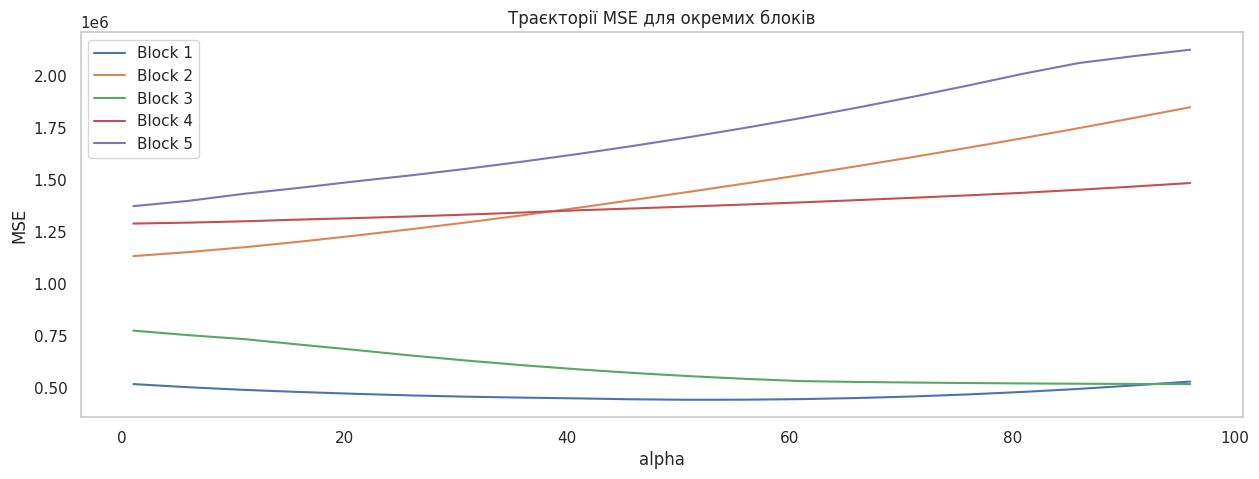

In [47]:
# Знаходимо значення alpha, що відповідають мінімумам MSE на кожному розбитті
alpha_min_mse = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]

# Виводимо значення alpha
for i, alpha in enumerate(alpha_min_mse):
    print(f"Block {i+1}: {alpha}")

# Побудова графіків для кожного стовпця mse_path_
plt.figure(figsize=(15, 5))

for i in range(regressor.mse_path_.shape[1]):
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f'Block {i+1}')

plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Траєкторії MSE для окремих блоків')
plt.legend()
plt.grid()
plt.show()


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [51]:

# Відсортуйте коефіцієнти за їх абсолютними значеннями
sorted_coef_index = np.argsort(np.abs(regressor.coef_))[::-1]

# Виберіть 4 ознаки з найбільшими позитивними коефіцієнтами
top_features_index = sorted_coef_index[:4]

# Отримайте назви цих ознак
top_features = df.columns[top_features_index]

print("Чотири ознаки з найбільшими позитивними коефіцієнтами:")
for feature in top_features:
    print(feature)



Чотири ознаки з найбільшими позитивними коефіцієнтами:
yr
weathersit
season
holiday


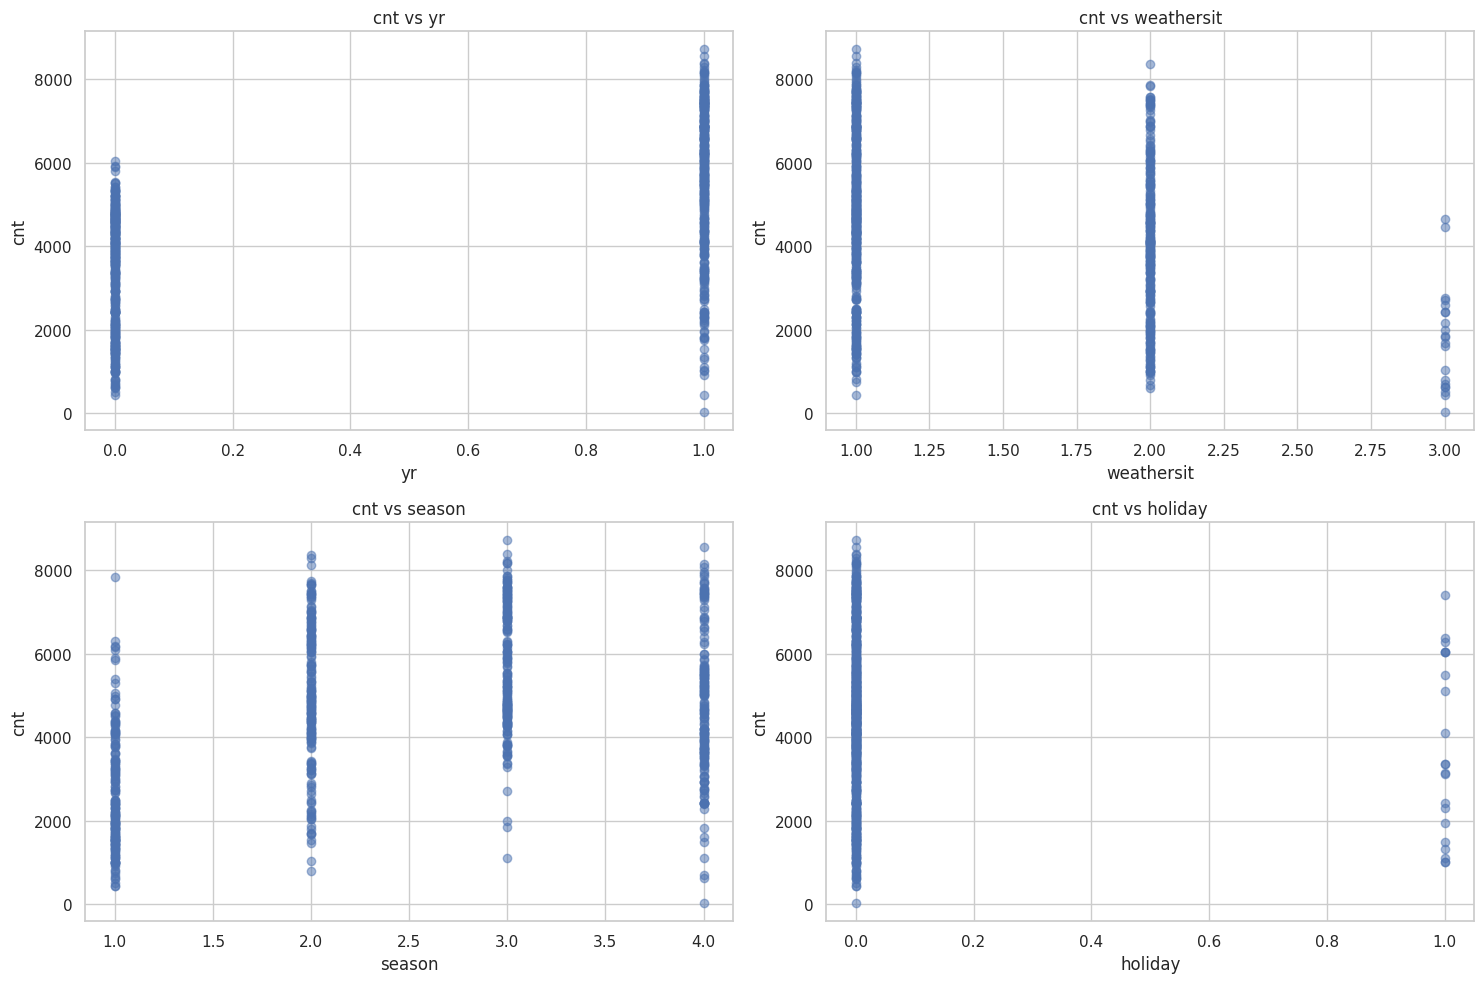

In [52]:
# Побудова графіків залежностей кількості прокатів від кожної з обраних ознак
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_features):
    plt.subplot(2, 2, i + 1)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.title('cnt vs ' + feature)
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

In [53]:
# Відсортуйте коефіцієнти за їх абсолютними значеннями
sorted_coef_index = np.argsort(np.abs(regressor.coef_))

# Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами
top_negative_features_index = sorted_coef_index[:3]

# Отримайте назви цих ознак
top_negative_features = df.columns[top_negative_features_index]

print("Три ознаки з найбільшими за модулем негативними коефіцієнтами:")
for feature in top_negative_features:
    print(feature)


Три ознаки з найбільшими за модулем негативними коефіцієнтами:
windspeed(ms)
hum
mnth


<ipython-input-54-38efc3272216>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['cnt'] = df['cnt']


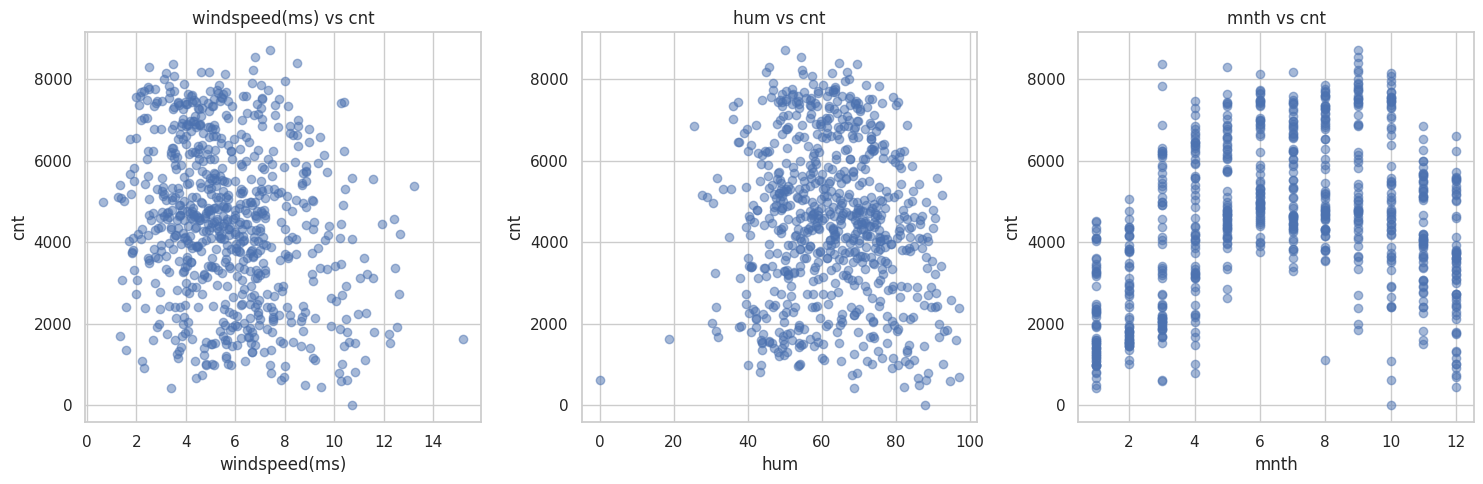

In [54]:
# Виберемо дані для візуалізації
data_to_plot = df[top_negative_features]

# Додамо до них цільову змінну cnt
data_to_plot['cnt'] = df['cnt']

# Побудуємо графіки
plt.figure(figsize=(15, 5))
for i, feature in enumerate(top_negative_features):
    plt.subplot(1, 3, i+1)
    plt.scatter(data_to_plot[feature], data_to_plot['cnt'], alpha=0.5)
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')
plt.tight_layout()
plt.show()

__Відповідь:__

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [61]:
print(coefs_lasso)





[[ 509.74296257 2040.65867996  -38.97055213 -518.64859449   69.06097068
   120.33788653 -610.92282714   49.5048134    71.449701    -10.19025515
   -38.17436672   -0.        ]
 [ 509.45281498 2040.25621742  -38.88943663 -515.55808989   69.04981422
   120.16602822 -610.34503326   49.67420564   71.3095701   -10.20502104
   -38.18953571   -0.        ]
 [ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 477.32591467 1996.24931816  -29.92697086 -171.77719511   68.25910797
   101.79300668 -545.45447186   51.34556518   71.49410924  -11.91744494
   -39.30755407   -0.        ]
 [ 297.07442417 1608.4605901     9.23821408   -0.           37.80311401
     0.           -4.85009184   37.3541199    95.92588228  -26.3545609
   -48.10976518   -0.        ]]


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.